<a href="https://colab.research.google.com/github/gonzalo-marrero/stellar_spectra_analysis/blob/main/Spectra_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
"""
Stellar Spectra Analysis
Autores originales: Gonzalo Marrero, Pablo Jiménez, Nöel Cortés
Mejoras añadidas por: Gonzalo Marrero (optimización, modularización y estructura para Google Colab)

Descripción:
Este notebook realiza:
- Carga de espectros .dat
- Visualización limpia por bloques
- Organización modular en Colab
- Generación automática de imágenes PNG
- Preparado para futura normalización y comparación espectral
"""


'\nStellar Spectra Analysis\nAutores originales: Gonzalo Marrero, Pablo Jiménez, Nöel Cortés\nMejoras añadidas por: Gonzalo Marrero (optimización, modularización y estructura para Google Colab)\n\nDescripción:\nEste notebook realiza:\n- Carga de espectros .dat\n- Visualización limpia por bloques\n- Organización modular en Colab\n- Generación automática de imágenes PNG\n- Preparado para futura normalización y comparación espectral\n'

In [5]:
# CELDA 1 — Instalar librerías y modo inline
%pip install -q specutils astropy

# Mostrar que matplotlib funciona inline
%matplotlib inline

print("Instalación completada. Versión de paquetes:")
import importlib, pkgutil
import astropy, specutils, matplotlib, numpy, scipy
print("astropy", astropy.__version__)
print("specutils", specutils.__version__)
print("matplotlib", matplotlib.__version__)
print("numpy", numpy.__version__)
print("scipy", scipy.__version__)


Instalación completada. Versión de paquetes:
astropy 7.1.1
specutils 2.2.0
matplotlib 3.10.0
numpy 2.0.2
scipy 1.16.3


In [6]:
# CELDA 2 — Verificar que las carpetas existen y listar archivos
import os

DATA_REF = "/content/data1"    # carpeta en Colab con archivos .dat o .txt
DATA_TARGET = "/content/data2"
PLOTS_DIR = "/content/plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

print("¿Existe DATA_REF?", os.path.isdir(DATA_REF))
print("¿Existe DATA_TARGET?", os.path.isdir(DATA_TARGET))
print("\nArchivos en DATA_REF:")
print(sorted(os.listdir(DATA_REF))[:50])   # muestra hasta 50
print("\nArchivos en DATA_TARGET:")
print(sorted(os.listdir(DATA_TARGET))[:50])


¿Existe DATA_REF? True
¿Existe DATA_TARGET? True

Archivos en DATA_REF:
['.ipynb_checkpoints', 'ALS_18929_B0V.dat', 'BD+195116_M4p5V.dat', 'HD12014_K0Ib.dat', 'HD13267_B5Ia.dat', 'HD132933_M0I.dat', 'HD141004_G0V.dat', 'HD150898_B0Ib.dat', 'HD16901_G0I.dat', 'HD17378_A5Ia.dat', 'HD175588_M4II.dat', 'HD190429A_O4If.dat', 'HD201091_K5V.dat', 'HD20630_G5V.dat', 'HD20902_F5I.dat', 'HD219978_K4p5Ib.dat', 'HD23194_A5V.dat', 'HD27524_F5V.dat', 'HD31295_A0V.dat', 'HD3369_B5V.dat', 'HD3651_K0V.dat', 'HD37227_F0II.dat', 'HD46223_O4V.dat', 'HD6474_G4Ia.dat', 'HD69464_O7Ib(f).dat', 'HD79211_M0V.dat', 'HD87737_A0I.dat', 'HD8829_F0V.dat', 'HD91824_O7V.dat']

Archivos en DATA_TARGET:
['HD161695_prueba2.dat', 'HD78558_prueba1.dat', 'starprob1.dat', 'starprob2.dat']


In [7]:
# CELDA 3 — Función robusta para leer un archivo y mostrar información básica
import numpy as np
from astropy.io import ascii

def read_spectrum_any(path):
    """
    Intenta leer con astropy.io.ascii; si falla, usa numpy.loadtxt.
    Devuelve (wavelength, flux) como arrays numpy de tipo float.
    """
    try:
        table = ascii.read(path)
        # Buscar columnas numéricas plausibles
        cols = table.columns
        # Intentar varias opciones para columnas
        if len(cols) >= 2:
            col_names = list(cols.names)
            x = np.array(table[col_names[0]], dtype=float)
            y = np.array(table[col_names[1]], dtype=float)
            return x, y
        else:
            raise ValueError("Menos de 2 columnas detectadas en astropy table.")
    except Exception as e:
        # fallback numpy
        try:
            arr = np.loadtxt(path)
            if arr.ndim == 1 and arr.size >= 2:
                # vector — intentar dividir en dos columnas asumidas
                mid = arr.size // 2
                x = arr[:mid]
                y = arr[mid:]
                return x, y
            elif arr.ndim == 2 and arr.shape[1] >= 2:
                return arr[:,0].astype(float), arr[:,1].astype(float)
            else:
                raise ValueError("Formato inesperado en numpy.loadtxt.")
        except Exception as e2:
            raise RuntimeError(f"Error leyendo {path} con astropy ({e}) y numpy ({e2}).")

# Prueba con un archivo de referencia y uno target (si existen)
ref_list = sorted([f for f in os.listdir(DATA_REF) if f.lower().endswith((".txt",".dat"))])
targ_list = sorted([f for f in os.listdir(DATA_TARGET) if f.lower().endswith((".txt",".dat"))])

print("Primeros archivos detectados:")
print("REF:", ref_list[:5])
print("TARGET:", targ_list[:5])

if ref_list:
    sample_ref = os.path.join(DATA_REF, ref_list[0])
    wl, fl = read_spectrum_any(sample_ref)
    print(f"\n{ref_list[0]} -> points: {wl.size}")
    print("wavelength range:", wl.min(), "to", wl.max())
    print("flux range:", fl.min(), "to", fl.max())
    print("first 5 rows (wl,flux):")
    import numpy as _np
    print(_np.column_stack((wl[:5], fl[:5])))
else:
    print("No se encontraron archivos en DATA_REF.")


Primeros archivos detectados:
REF: ['ALS_18929_B0V.dat', 'BD+195116_M4p5V.dat', 'HD12014_K0Ib.dat', 'HD13267_B5Ia.dat', 'HD132933_M0I.dat']
TARGET: ['HD161695_prueba2.dat', 'HD78558_prueba1.dat', 'starprob1.dat', 'starprob2.dat']

ALS_18929_B0V.dat -> points: 2701
wavelength range: 3915.3516 to 5099.6182
flux range: 0.5294532 to 1.020558
first 5 rows (wl,flux):
[[3.9153516e+03 9.9669830e-01]
 [3.9157842e+03 9.9842880e-01]
 [3.9162168e+03 1.0005570e+00]
 [3.9166492e+03 9.9792810e-01]
 [3.9170818e+03 9.9306700e-01]]


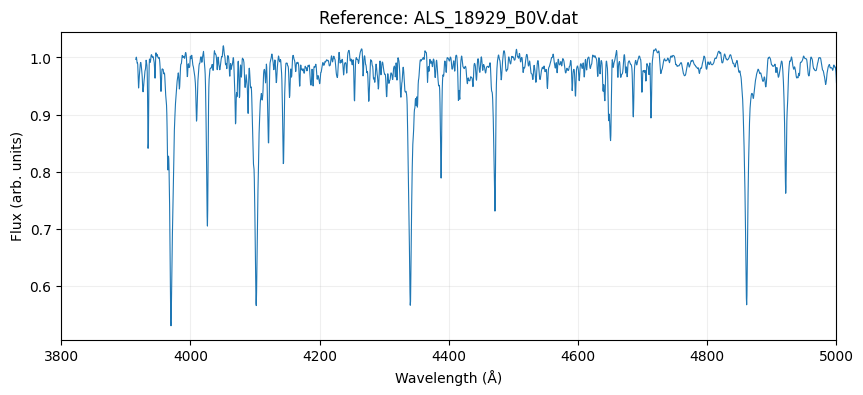

In [8]:
# CELDA 4 — Plotea el primer archivo de referencia (ver que se muestre)
import matplotlib.pyplot as plt

if ref_list:
    wl, fl = read_spectrum_any(os.path.join(DATA_REF, ref_list[0]))
    plt.figure(figsize=(10,4))
    plt.plot(wl, fl, lw=0.8)
    plt.title(f"Reference: {ref_list[0]}")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux (arb. units)")
    plt.xlim(3800, 5000)
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("No hay archivos de referencia para plotear.")


        Use Spectrum instead. [warnings]
        Use Spectrum instead.


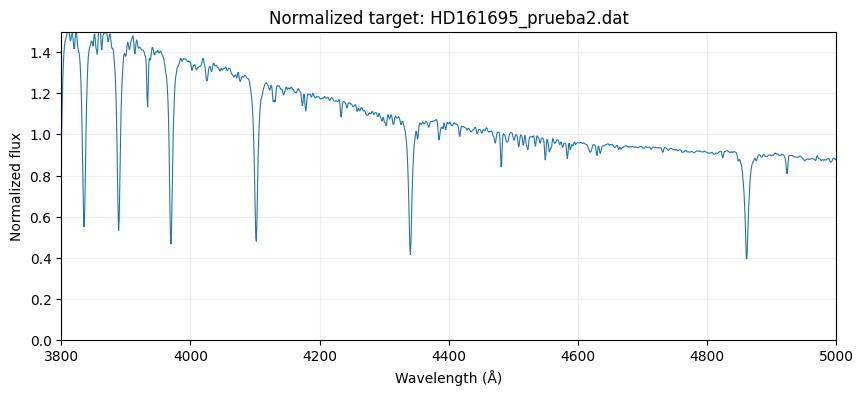

In [9]:
# CELDA 5 — Normalizar un target y mostrar resultado (prueba con el primer target)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_generic_continuum
from astropy import units as u

if targ_list:
    sample_target_path = os.path.join(DATA_TARGET, targ_list[0])
    wl_t, fl_t = read_spectrum_any(sample_target_path)
    # Detectar si wl está en Angstroms o nanómetros (heurística simple)
    wl_mean = wl_t.mean()
    # Si las longitudes medias son ~hundreds => en nm; si ~thousands => Å
    if wl_mean < 1000:
        # asumir nm -> convertir a Angstroms: 1 nm = 10 Å
        wl_ang = wl_t * 10.0
    else:
        wl_ang = wl_t.copy()
    # Crear Spectrum1D (especulamos que el flujo es adimensional o en Jy; `fit_generic_continuum` funciona con unidades)
    spec = Spectrum1D(flux=fl_t * u.Jy, spectral_axis=wl_ang * u.AA)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        continuum = fit_generic_continuum(spec)
    cont_vals = continuum(wl_ang * u.AA).value
    flux_norm = fl_t / cont_vals

    plt.figure(figsize=(10,4))
    plt.plot(wl_ang, flux_norm, lw=0.8)
    plt.title(f"Normalized target: {targ_list[0]}")
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Normalized flux")
    plt.xlim(3800,5000)
    plt.ylim(0, 1.5)
    plt.grid(alpha=0.2)
    plt.show()
else:
    print("No hay archivos target para normalizar.")


In [10]:
# CELDA 6 — Batch: graficar todas las referencias y normalizar+graficar todos los targets, guardando PNGs
import os

ref_files = sorted([f for f in os.listdir(DATA_REF) if f.lower().endswith((".txt",".dat"))])
targ_files = sorted([f for f in os.listdir(DATA_TARGET) if f.lower().endswith((".txt",".dat"))])

def safe_plot_save(wl, fl, fname, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(wl, fl, lw=0.8)
    plt.title(title)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux")
    plt.xlim(3800,5000)
    plt.ylim(0,1.5)
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

# Procesar referencias
for f in ref_files:
    path = os.path.join(DATA_REF, f)
    wl, fl = read_spectrum_any(path)
    # normalizar si quieres (aquí solo guardamos el espectro bruto)
    wl_ang = wl * 10.0 if wl.mean() < 1000 else wl
    savepath = os.path.join(PLOTS_DIR, f"ref_{os.path.splitext(f)[0]}.png")
    safe_plot_save(wl_ang, fl, savepath, title=f"Reference {f}")
print(f"Guardadas {len(ref_files)} figuras de referencia en {PLOTS_DIR}")

# Procesar targets (normalizando)
for f in targ_files:
    path = os.path.join(DATA_TARGET, f)
    wl, fl = read_spectrum_any(path)
    wl_ang = wl * 10.0 if wl.mean() < 1000 else wl
    spec = Spectrum1D(flux=fl * u.Jy, spectral_axis=wl_ang * u.AA)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        continuum = fit_generic_continuum(spec)
    cont_vals = continuum(wl_ang * u.AA).value
    flux_norm = fl / cont_vals
    savepath = os.path.join(PLOTS_DIR, f"target_{os.path.splitext(f)[0]}_norm.png")
    safe_plot_save(wl_ang, flux_norm, savepath, title=f"Target {f} (normalized)")
print(f"Guardadas {len(targ_files)} figuras de target normalizadas en {PLOTS_DIR}")


Guardadas 28 figuras de referencia en /content/plots


        Use Spectrum instead. [warnings]
        Use Spectrum instead.
        Use Spectrum instead. [warnings]
        Use Spectrum instead.
        Use Spectrum instead. [warnings]
        Use Spectrum instead.
        Use Spectrum instead. [warnings]
        Use Spectrum instead.


Guardadas 4 figuras de target normalizadas en /content/plots


Imágenes guardadas: 32


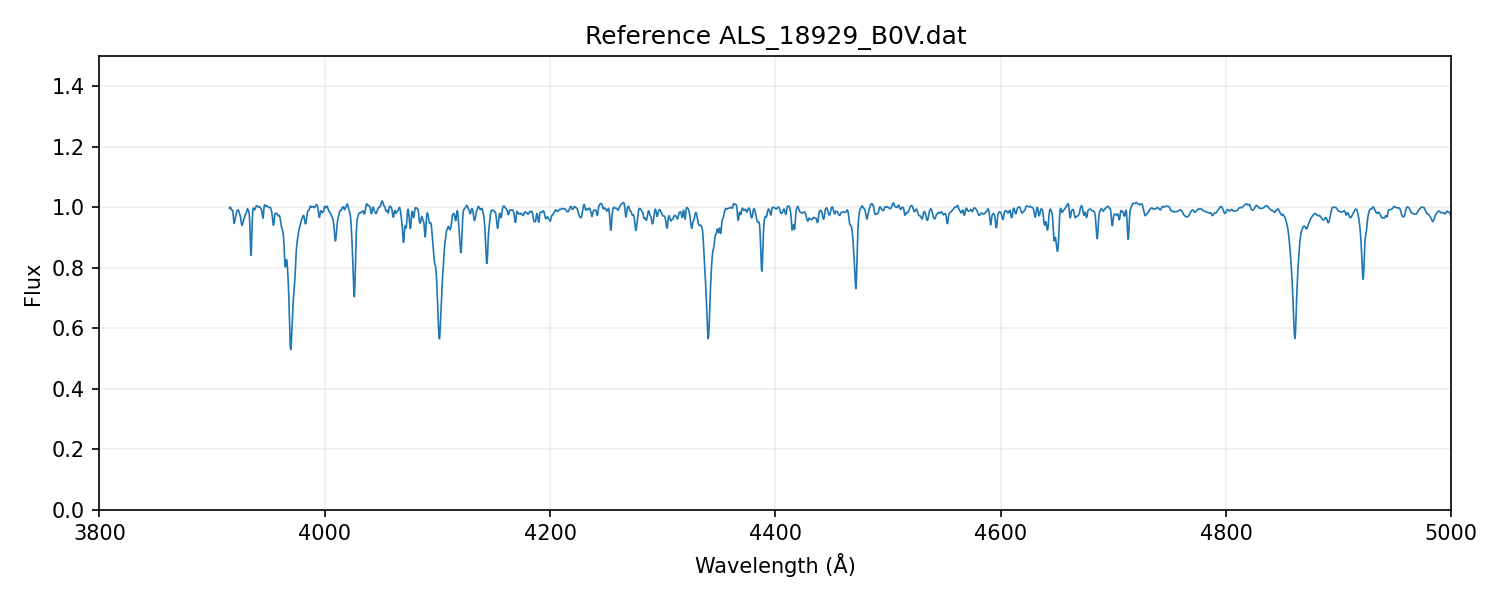

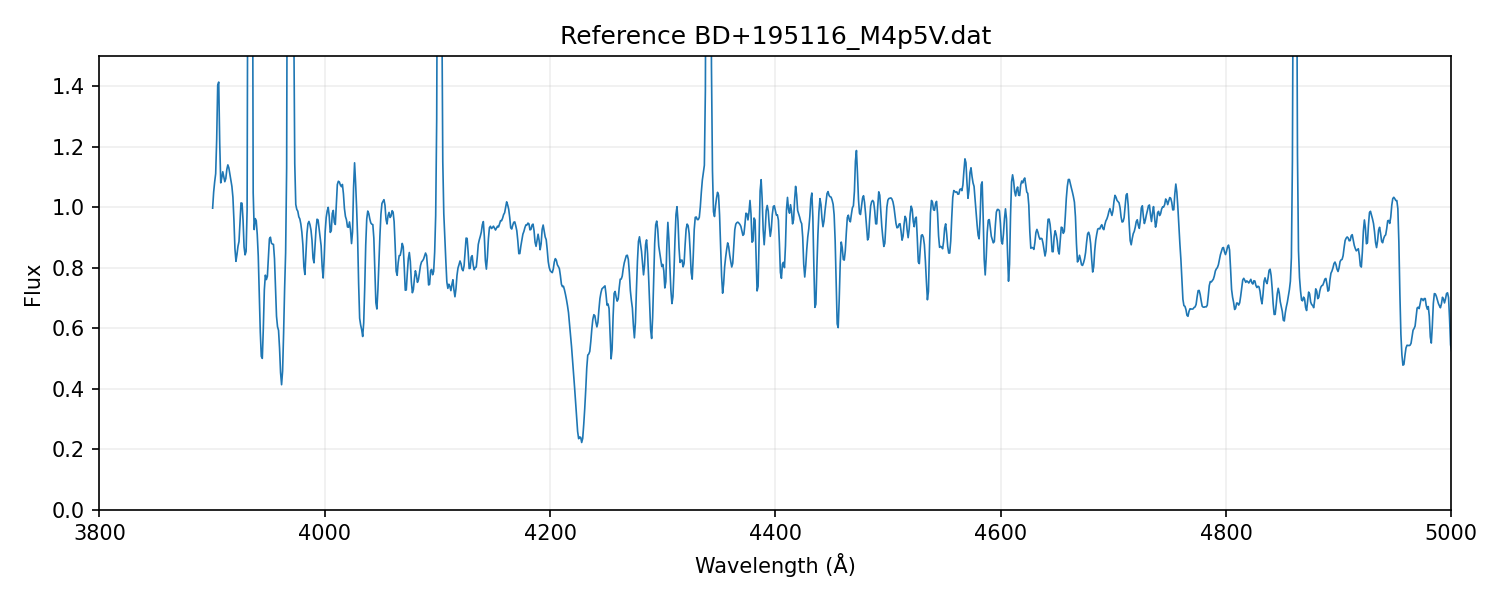

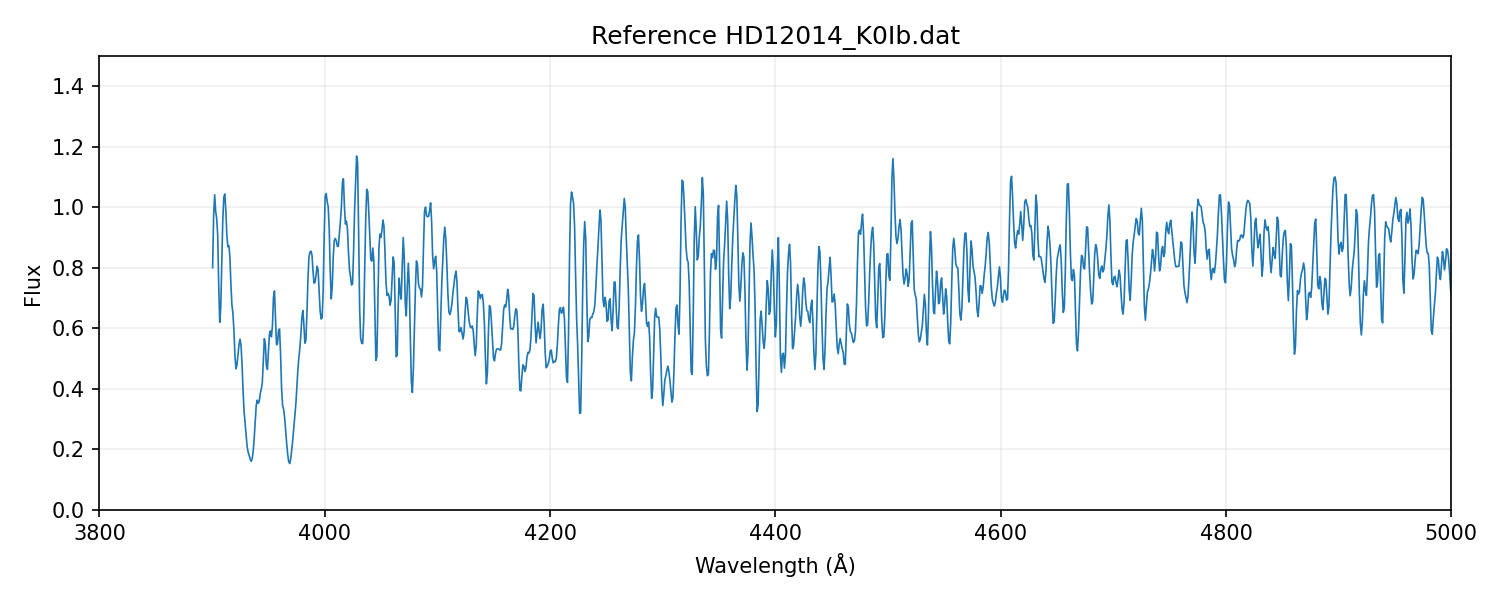

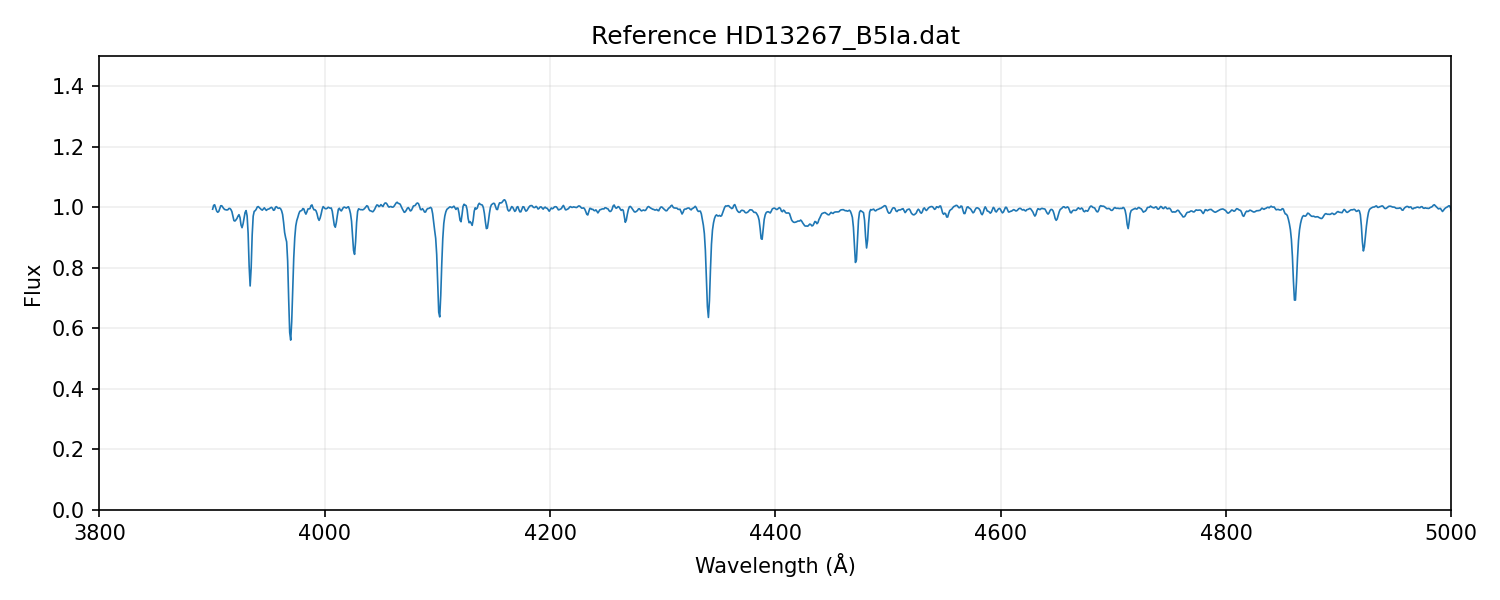

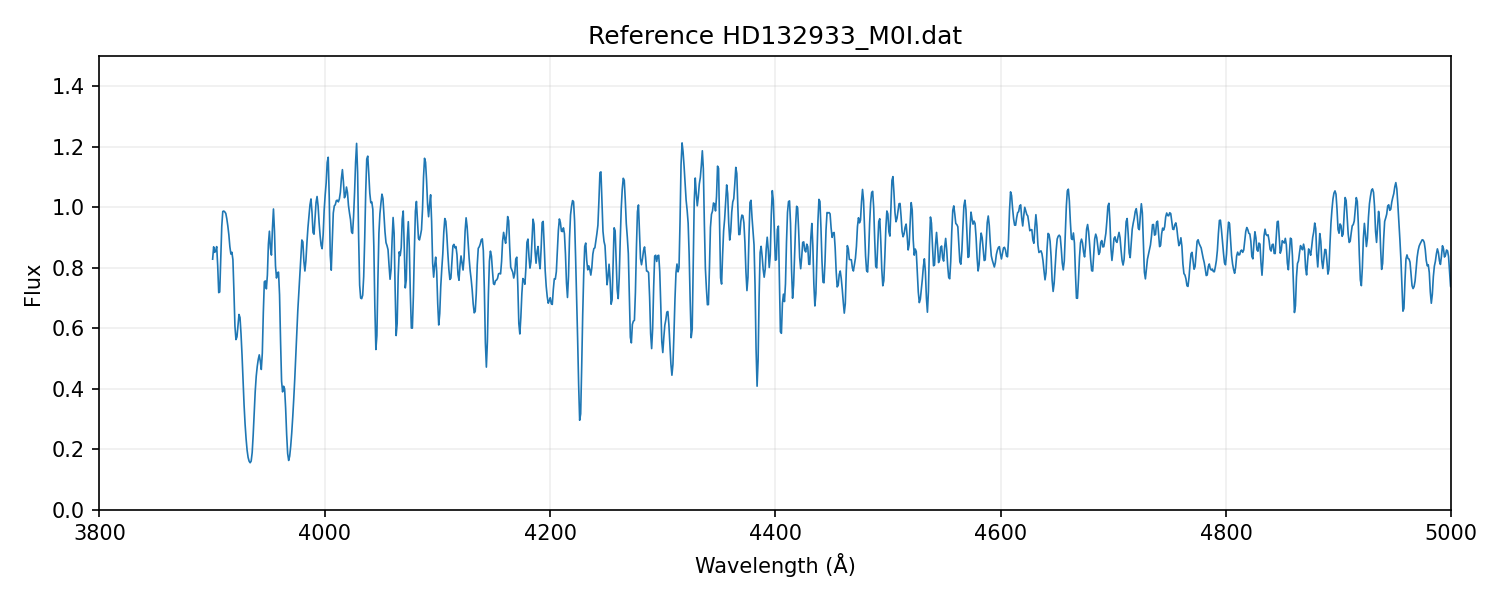

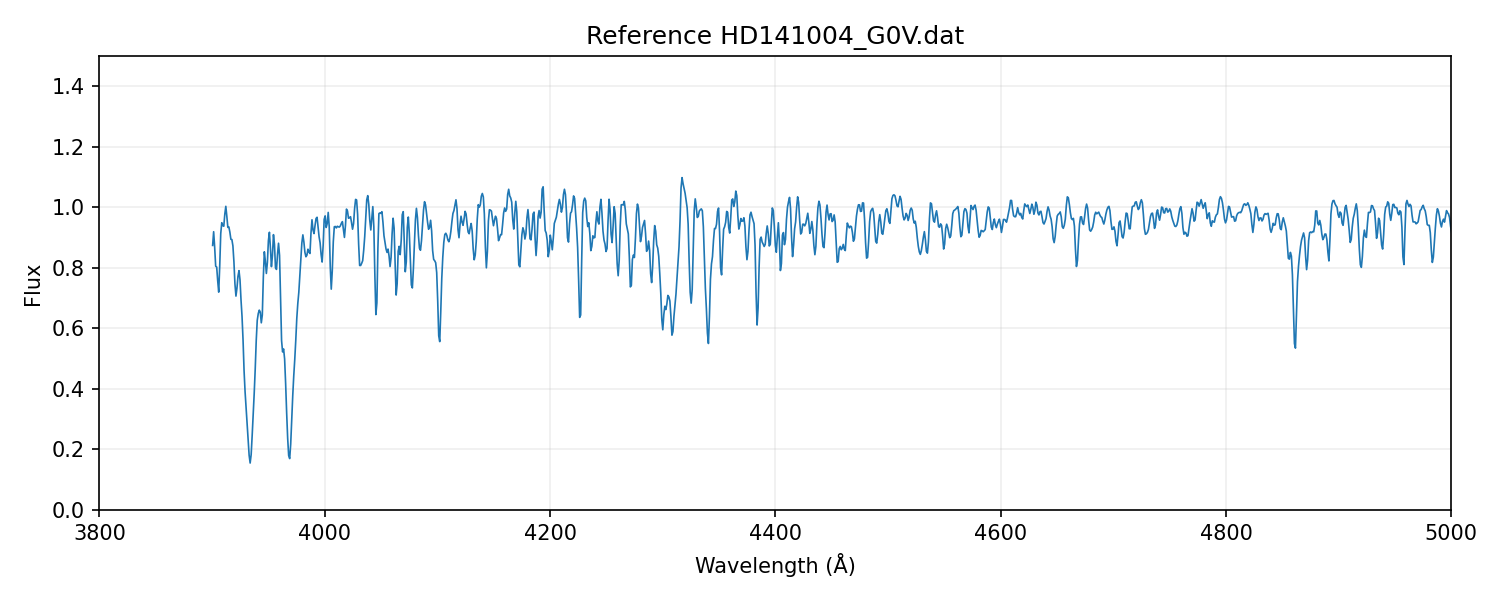

In [11]:
# CELDA 7 — Mostrar las primeras 6 imágenes guardadas
from IPython.display import Image, display
imgs = sorted([os.path.join(PLOTS_DIR,p) for p in os.listdir(PLOTS_DIR) if p.endswith(".png")])
print("Imágenes guardadas:", len(imgs))
for im in imgs[:6]:
    display(Image(im, width=800))


In [12]:
# CELDA 8 — Funciones de matching espectral

import numpy as np
from scipy.interpolate import interp1d

def compare_spectra(wl_ref, fl_ref, wl_tar, fl_tar):
    """
    Interpola target al grid del ref y calcula métricas:
    - correlación normalizada
    - RMS error

    Devuelve: (correlation, rms)
    """
    # Interpolamos target al grid de referencia
    f_interp = interp1d(wl_tar, fl_tar, bounds_error=False, fill_value=np.nan)
    fl_tar_interp = f_interp(wl_ref)

    # Quitamos NaNs por bordes
    mask = ~np.isnan(fl_tar_interp)
    fl_r = fl_ref[mask]
    fl_t = fl_tar_interp[mask]

    # Normalizamos
    fl_r_n = (fl_r - fl_r.mean()) / fl_r.std()
    fl_t_n = (fl_t - fl_t.mean()) / fl_t.std()

    # Correlación
    corr = np.corrcoef(fl_r_n, fl_t_n)[0,1]

    # RMS
    rms = np.sqrt(np.mean((fl_r_n - fl_t_n)**2))

    return corr, rms


In [13]:
# CELDA 9 — tabla de matching global

matching_results = {}  # dict {target_file: [(ref, corr, rms), ...]}

for tfile in targ_files:
    wl_t, fl_t = read_spectrum_any(os.path.join(DATA_TARGET, tfile))
    wl_t = wl_t * 10.0 if wl_t.mean() < 1000 else wl_t

    comparisons = []
    for rfile in ref_files:
        wl_r, fl_r = read_spectrum_any(os.path.join(DATA_REF, rfile))
        wl_r = wl_r * 10.0 if wl_r.mean() < 1000 else wl_r

        corr, rms = compare_spectra(wl_r, fl_r, wl_t, fl_t)
        comparisons.append((rfile, corr, rms))

    # Ordenar por correlación (mayor = mejor)
    comparisons_sorted = sorted(comparisons, key=lambda x: -x[1])
    matching_results[tfile] = comparisons_sorted

print("Comparación completada.")


Comparación completada.


In [14]:
# CELDA 10 — Tabla resumen

import pandas as pd

rows = []

for tfile, comp_list in matching_results.items():
    for i,(ref,corr,rms) in enumerate(comp_list[:3]):  # top 3
        rows.append({
            "Target": tfile,
            "Rank": i+1,
            "Reference Match": ref,
            "Correlation": corr,
            "RMS": rms
        })

df_results = pd.DataFrame(rows)
df_results


,Target,Rank,Reference Match,Correlation,RMS
0,HD161695_prueba2.dat,1,HD175588_M4II.dat,0.462689,1.036640
1,HD161695_prueba2.dat,2,HD46223_O4V.dat,0.269292,1.208891
2,HD161695_prueba2.dat,3,HD87737_A0I.dat,0.263566,1.213618
3,HD78558_prueba1.dat,1,HD141004_G0V.dat,0.942109,0.340267
4,HD78558_prueba1.dat,2,HD20630_G5V.dat,0.937987,0.352174
5,HD78558_prueba1.dat,3,HD3651_K0V.dat,0.896945,0.453994
6,starprob1.dat,1,HD3651_K0V.dat,0.693976,0.782335
7,starprob1.dat,2,HD12014_K0Ib.dat,0.672031,0.809900
8,starprob1.dat,3,HD141004_G0V.dat,0.597797,0.896887
9,starprob2.dat,1,HD175588_M4II.dat,0.412248,1.084206


In [15]:
# CELDA 11 — Exportar a CSV
csv_path = "/content/matching_results.csv"
df_results.to_csv(csv_path, index=False)
csv_path


'/content/matching_results.csv'

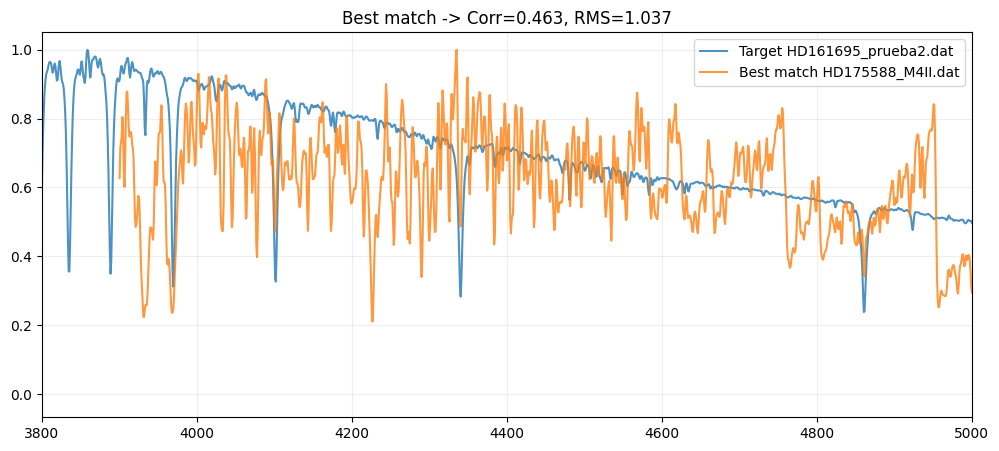

In [16]:
# CELDA 12 — Plot de comparación target / mejor referencia

def plot_best_match(target_file):
    best_ref, best_corr, best_rms = matching_results[target_file][0]

    wl_t, fl_t = read_spectrum_any(os.path.join(DATA_TARGET, target_file))
    wl_t = wl_t * 10.0 if wl_t.mean() < 1000 else wl_t

    wl_r, fl_r = read_spectrum_any(os.path.join(DATA_REF, best_ref))
    wl_r = wl_r * 10.0 if wl_r.mean() < 1000 else wl_r

    plt.figure(figsize=(12,5))
    plt.plot(wl_t, fl_t / fl_t.max(), label=f"Target {target_file}", alpha=0.8)
    plt.plot(wl_r, fl_r / fl_r.max(), label=f"Best match {best_ref}", alpha=0.8)
    plt.title(f"Best match -> Corr={best_corr:.3f}, RMS={best_rms:.3f}")
    plt.xlim(3800,5000)
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Ejemplo con el PRIMER target
plot_best_match(targ_files[0])
